In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import csv
import math
from scipy import optimize
from scipy import stats

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)

gyro = 1.6e-19/9.1e-31 #Gyromagnetic magnetic ratio (C/kg)

def Lorentzian(H, S, A, Delta, H0, V): 
    return ((S*Delta**2)+(A*(H-H0)*Delta))/(Delta**2+(H-H0)**2)+V
def damping(f, alpha, delta0):
    return 2*np.pi*(f*1e9)*alpha*10000/gyro+delta0
def Kittel(H0, demag):
    return gyro/(2*np.pi)*(np.sqrt(H0*(H0+demag)))*1e-13
def data_slicing(sliced_array,slicing_ind):
    n = np.sum(slicing_ind)
    np.append(sliced_array,0)
    output = []
    if len(sliced_array) == n:
        cnt = 0
        for i in range(len(slicing_ind)):
            i_start=cnt
            cnt+=slicing_ind[i]
            i_stop=cnt
            output.append(sliced_array[i_start:i_stop])
    return output
def Angdep(p, Yd, Xd, Zf, a):
    p=p/180*np.pi
    a=a/180*np.pi
    return Yd*np.cos(p+a)*np.sin(2*(p+a))+Xd*np.sin(p+a)*np.sin(2*(p+a))+Zf*np.sin(2*(p+a))

# Angle-dependent ST-FMR fitting

Here the freq is replaced by the nominal degree defined by substrate direction

In [64]:
io = r'/Users/didierjim/Documents/SCREAM/_Measurement/2022-09-Co torque/10MgO10/*deg'
Sample_name = '8.00'
files = sorted(glob.glob(os.path.join(io,'*'+Sample_name+'*')), key = lambda path:float(path.split('/')[-2].split('deg')[0]))
#print(files[1])

In [65]:
fs = []
for i in range(len(files)):
    fs.append(float(files[i].split('/')[-2].split('deg')[0]))
#print(fs)

file_count = []
freq = [] # Here is degree (filename, defined by substrate but not H field)
cnt = 1
for j in range(1,len(files)):
    if fs[j] == fs[j-1]:
        cnt += 1
    else:
        file_count.append(cnt)
        freq.append(fs[j-1])
        cnt = 1
    if j == len(files)-1:
        file_count.append(cnt)
        freq.append(fs[j])
print(np.sum(file_count), file_count)
print(freq)
file_times = []
for i in range(len(files)):
    a=files[i].split('/')[-1].split('_')[-1].split('.')[0][-5:]
    file_times.append(a)
    #print(a)
    
# Find zero_ind
import_files = pd.read_csv(files[0])
result = import_files.values
zero_ind = int(np.where(result[:,0]== -300)[0])
print('zero field index = ',zero_ind)

# Find measured field
f_range = int(result[0,0])
f_step = int(result[0,0]-result[1,0])

gaussscan = f'/Users/didierjim/Documents/SCREAM/_Measurement/ST-FMR field calibration/220406/\
step{f_step}/{f_range}FIX.csv'
x2 = np.loadtxt(gaussscan,delimiter=',',skiprows=1,usecols=(0,2,))
print(np.shape(x2[:,:]))

24 [2, 2, 2, 2, 3, 4, 3, 3, 3]
[-90.0, -75.0, -60.0, -40.0, -30.0, -15.0, 0.0, 15.0, 30.0]
zero field index =  165
(301, 2)


RuntimeError (-) -40.0 2022-09-16-17-23-53.csv


<ipython-input-66-b1f027686ad9>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,5))


<Figure size 1080x720 with 0 Axes>

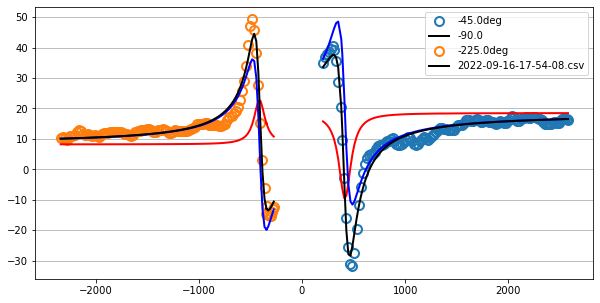

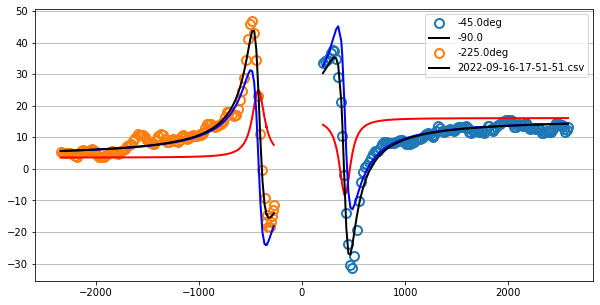

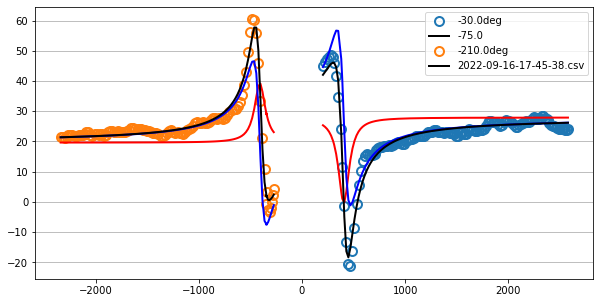

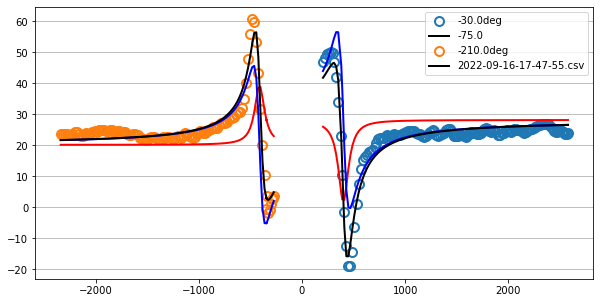

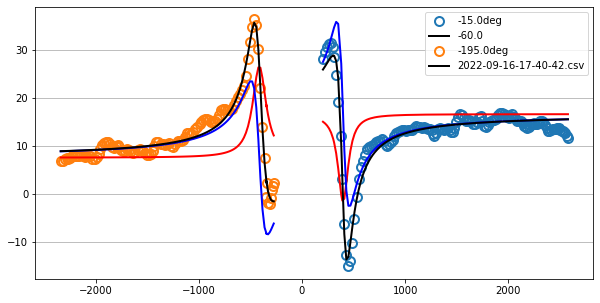

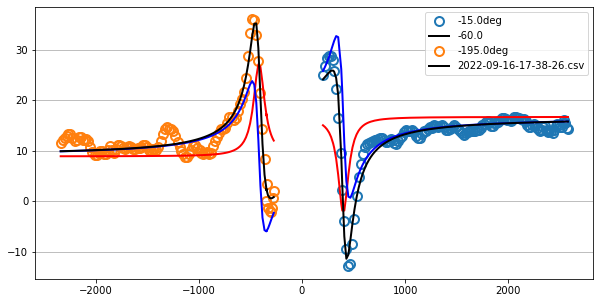

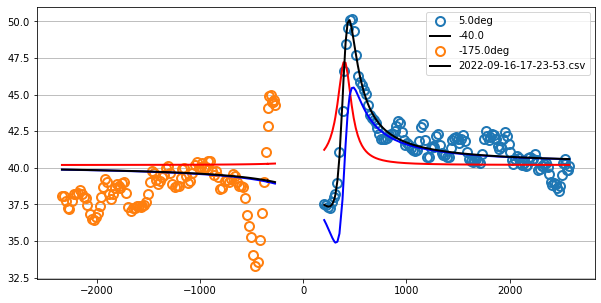

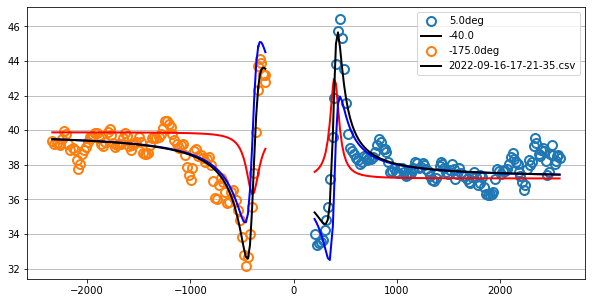

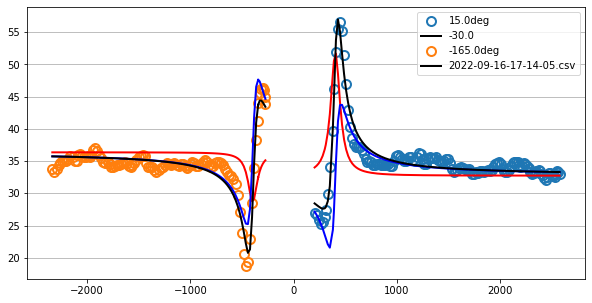

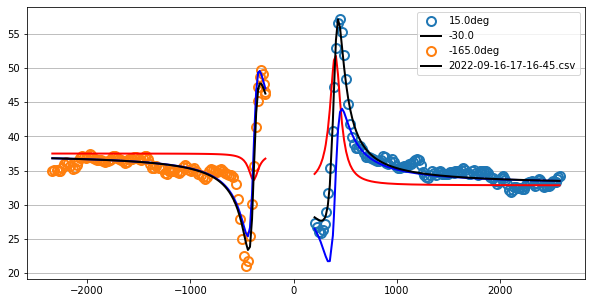

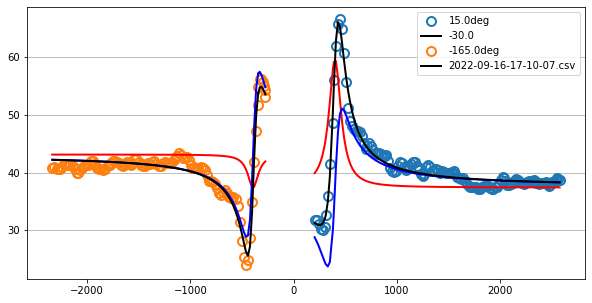

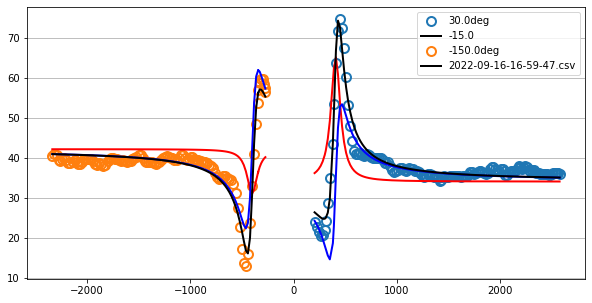

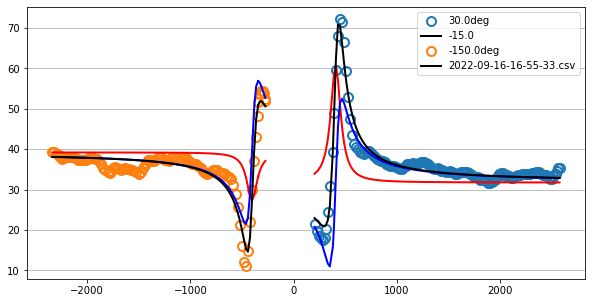

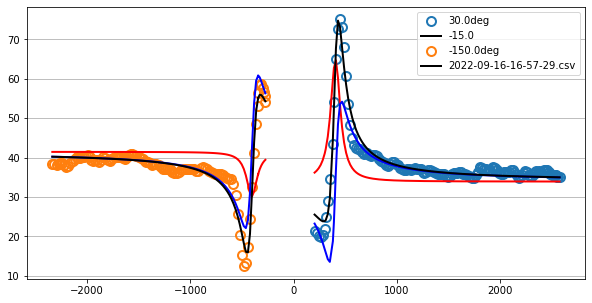

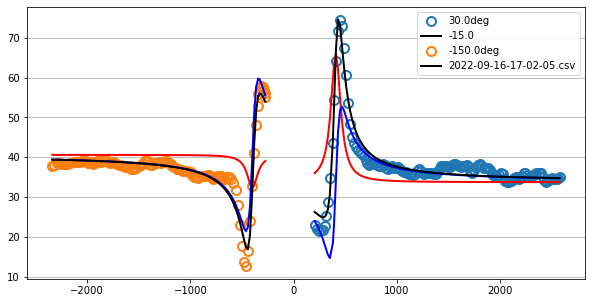

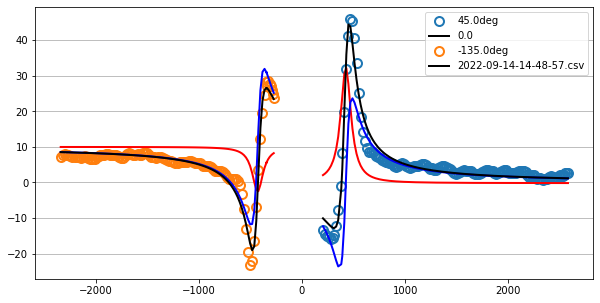

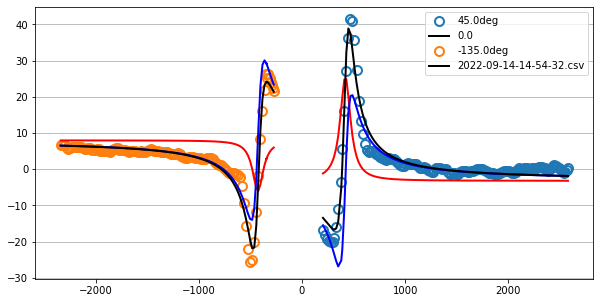

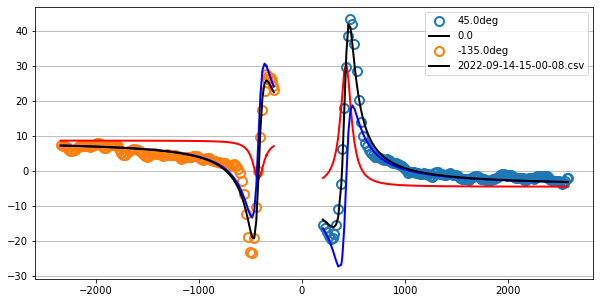

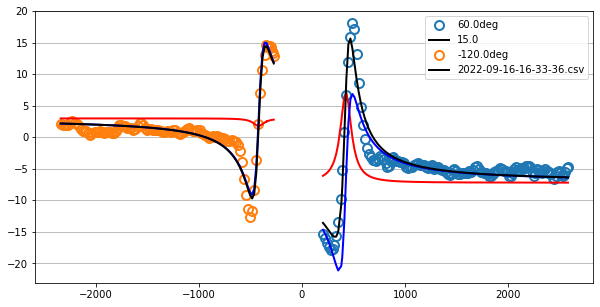

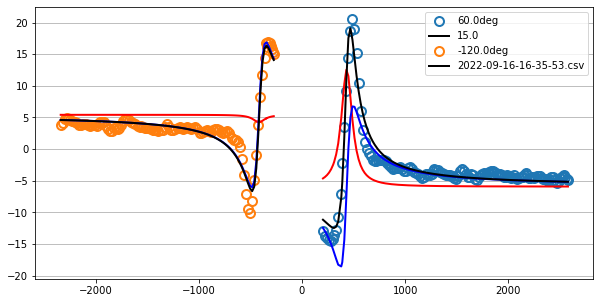

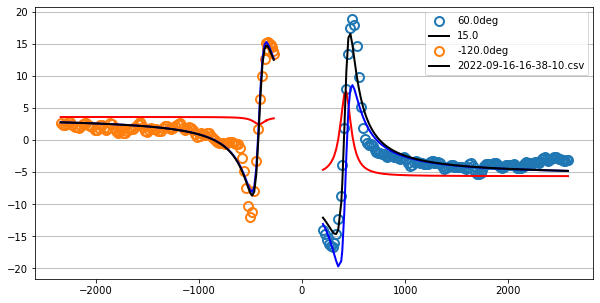

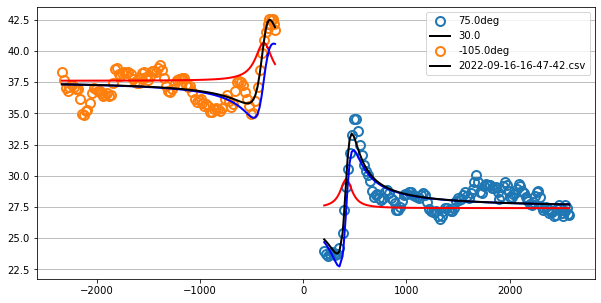

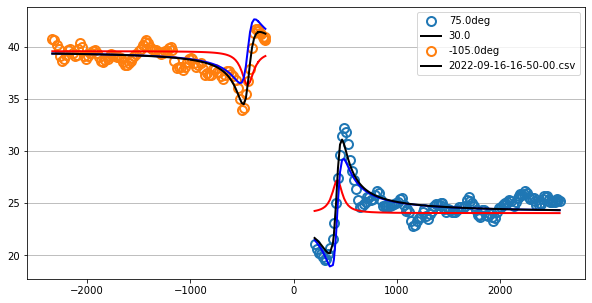

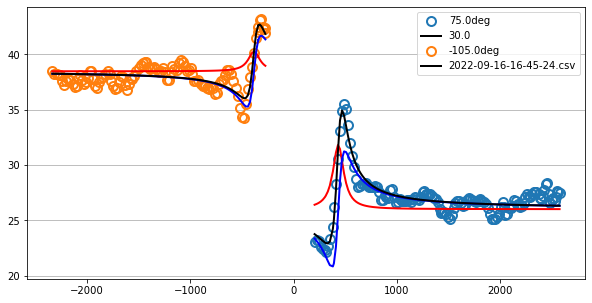

In [66]:
para_p = np.zeros((len(files), 6))
para_n = np.zeros((len(files), 6))
std_err_p = []
std_err_n = []

curves_p = []
curves_n = []

plt.figure(figsize = (15,10))
for i in range(len(files)):
    import_files = pd.read_csv(files[i])
    result = import_files.values
        
    results = pd.read_csv(files[i])
    length = len(results.values[:,0])
    H_p0 = results.values[int(length*0.05):int(length*0.51),0]+300
    H_p = x2[int(length*0.05):int(length*0.51),1]*-1-125-15
    Vmix_p = results.values[int(length*0.05):int(length*0.51),1]
    
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_p,Vmix_p, [0.0, 0.0, 100, 800, 280])
    except RuntimeError:
        print('RuntimeError (+)',fs[i],files[i].split('/')[-1].split('_')[-1])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.figure(figsize = (10,5))
    plt.grid(axis = 'y')
    plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, label = str(fs[i]+45)+'deg')
    plt.plot(H_p, Lorentzian(H_p,para_L[0],0,para_L[2],para_L[3],para_L[4]), color = 'red', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,0,para_L[1],para_L[2],para_L[3],para_L[4]), color = 'blue', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = fs[i],color = 'black', linewidth = 2)
    para_p[i,0] = fs[i]
    para_p[i,1:] = para_L
    std_err_p.append(np.sqrt(np.diag(cov_L))[2])
    

    H_n0 = results.values[int(length*0.58):int(length*0.95),0]+300
    H_n = x2[int(length*0.58):int(length*0.95),1]*-1-125-15
    Vmix_n = results.values[int(length*0.58):int(length*0.95),1]
    #plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9)
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_n,Vmix_n, [0.0, 0.0, -100, -800, 280])
    except RuntimeError:
        print('RuntimeError (-)',fs[i],files[i].split('/')[-1].split('_')[-1])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.plot(H_n,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, label = str(fs[i]-135)+'deg')
    plt.plot(H_n, Lorentzian(H_n,para_L[0],0,para_L[2],para_L[3],para_L[4]), color = 'red', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,0,para_L[1],para_L[2],para_L[3],para_L[4]), color = 'blue', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]), label = files[i].split('/')[-1].split('_')[-1],color = 'black', linewidth = 2)
    para_n[i,0] = fs[i]
    para_n[i,1:] = para_L
    std_err_n.append(np.sqrt(np.diag(cov_L))[2])
    
    if i==0:
        curves_p.append(x2[:zero_ind,1]*-1-125)
        curves_n.append(x2[zero_ind:,1]*-1-125)
    
    curves_p.append(results.values[:zero_ind,1]-para_p[i,-1])
    curves_n.append(results.values[zero_ind:,1]-para_n[i,-1])
    

    plt.legend()

In [67]:
para_n[:,2] = para_n[:,2]*-1
para_n[:,4] = para_n[:,4]*-1
para_p[:,0] += 45
para_n[:,0] += 225

t = ['fix', 'S', 'A', 'Delta', 'H0', 'V0', 'S/A']
para_pn = np.zeros((len(files)*2,7))
for i in range(len(files)):
    para_pn[2*i,:-1] = para_p[i,:]
    para_pn[2*i+1,:-1] = para_n[i,:]
    
para_pn[:,-1] = para_pn[:,1]/para_pn[:,2]
#print(para_pn)

tt = ['ang', 'S', 'S_err', 'A', 'A_err', 'Delta', 'Delta_err', 'H0', 'H0_err', 'V0','V0_err', 'S/A','S/A_err']
para_pn_avg = np.zeros((len(freq),13))
para_p_avg = np.zeros((len(freq),13))
para_n_avg = np.zeros((len(freq),13))
para_pn_avg[:,0] = freq
para_p_avg[:,0] = freq
para_n_avg[:,0] = freq
#print('f',freq)
for i in range(6):
    para_slice = data_slicing(para_pn[:,i+1],np.array(file_count)*2)
    if i != 5:
        p_slice = data_slicing(para_p[:,i+1],file_count)
        n_slice = data_slicing(para_n[:,i+1],file_count)
    else:
        p_slice = data_slicing(para_p[:,1]/para_p[:,2],file_count)
        n_slice = data_slicing(para_n[:,1]/para_n[:,2],file_count)
        
    for k in range(len(file_count)):
        para_pn_avg[k,2*i+1] = np.mean(para_slice[k])
        para_pn_avg[k,2*i+2] = np.std(para_slice[k])
        para_p_avg[k,2*i+1] = np.mean(p_slice[k])
        para_p_avg[k,2*i+2] = np.std(p_slice[k])
        para_n_avg[k,2*i+1] = np.mean(n_slice[k])
        para_n_avg[k,2*i+2] = np.std(n_slice[k])

    #print(tt[2*i+1], np.around(para_p_avg[:,2*i+1],2),'\n\t',np.around(para_n_avg[:,2*i+1],2))
    #print(tt[2*i+2], np.around(para_p_avg[:,2*i+2],2),'\n\t',np.around(para_n_avg[:,2*i+2],2))

pd.DataFrame(np.around(np.vstack((para_p_avg,para_n_avg)),2), columns=tt)

,ang,S,S_err,A,A_err,Delta,Delta_err,H0,H0_err,V0,V0_err,S/A,S/A_err
0,-90.0,-26.39,1.81,-59.15,1.03,67.85,2.03,416.13,0.15,17.30,1.20,0.45,0.02
1,-75.0,-27.33,0.92,-57.80,0.34,61.43,2.24,402.81,1.96,28.07,0.14,0.47,0.01
2,-60.0,-18.72,0.35,-35.56,3.23,60.40,0.37,399.12,1.00,16.67,0.03,0.53,0.06
3,-40.0,6.48,0.63,10.05,0.58,66.28,15.07,398.07,1.34,38.70,1.49,0.64,0.03
4,-30.0,20.19,1.48,24.05,2.33,62.05,6.52,403.10,1.70,34.32,2.19,0.84,0.02
5,-15.0,30.84,1.22,39.81,1.38,56.85,1.12,407.42,1.06,33.38,0.95,0.78,0.06
6,0.0,32.23,2.67,47.32,0.65,60.61,0.51,423.69,2.54,-2.64,1.82,0.68,0.06
7,15.0,15.42,2.26,27.39,1.27,63.01,0.65,427.07,4.78,-6.25,0.69,0.57,0.11
8,30.0,3.78,1.47,10.10,0.53,63.10,4.21,424.23,6.71,25.82,1.38,0.37,0.13
9,-90.0,18.09,3.46,55.91,0.24,67.66,3.85,417.43,5.49,5.89,2.32,0.32,0.06


No handles with labels found to put in legend.


S =  [30.22661869 -3.30395157  8.16034594 -0.52902707] 
A =  [ 65.70029819 -10.00745667   1.86900386  -2.32713943]
S
30.2266186888347 1.2719693629271869 8.160345939209495 0.6275814419450149 -3.3039515740670837 1.7641657880726804
30.226619*cos((x+-0.529)/180*pi)*sin(2*(x+-0.529)/180*pi)
    +-3.303952*sin((x+-0.529)/180*pi)*sin(2*(x+-0.529)/180*pi)
    +8.160346*sin(2*(x+-0.529)/180*pi)
A
65.70029818639529 1.2820286198354216 1.8690038619834313 0.6398376030920869 -10.007456669779843 1.7768246757079063
65.700298*cos((x+-2.327)/180*pi)*sin(2*(x+-2.327)/180*pi)
    +-10.007457*sin((x+-2.327)/180*pi)*sin(2*(x+-2.327)/180*pi)
    +1.869004*sin(2*(x+-2.327)/180*pi)


,54-08,51-51,45-38,47-55,40-42,38-26,23-53,21-35,14-05,16-45,10-07,59-47,55-33,57-29,02-05,48-57,54-32,00-08,33-36,35-53,38-10,47-42,50-00,45-24
phi,-90.00,-90.00,-75.00,-75.00,-60.00,-60.00,-40.00,-40.00,-30.00,-30.00,-30.00,-15.00,-15.00,-15.00,-15.00,0.00,0.00,0.00,15.00,15.00,15.00,30.00,30.00,30.00
S+,-28.21,-24.58,-28.25,-26.41,-18.37,-19.07,7.11,5.85,19.12,19.16,22.29,31.08,28.97,30.94,32.39,32.56,28.80,35.32,14.37,18.56,13.33,2.34,3.20,5.81
S-,14.63,21.55,19.67,19.12,19.13,18.48,7.11,-3.60,-7.69,-3.91,-5.77,-11.16,-11.93,-11.32,-8.36,-12.59,-14.05,-11.08,-1.20,-1.18,-1.13,3.08,-3.26,1.79
A+,-60.18,-58.12,-58.14,-57.47,-38.78,-32.33,10.64,9.47,22.32,22.48,27.35,38.86,41.54,40.74,38.11,47.78,47.78,46.41,28.12,25.61,28.45,9.35,10.47,10.50
A-,56.15,55.67,54.36,51.25,32.12,29.88,-10.64,-10.46,-22.58,-24.24,-28.73,-39.57,-35.40,-38.74,-38.40,-43.97,-44.23,-43.90,-24.16,-22.94,-23.37,-5.96,-6.15,-6.43


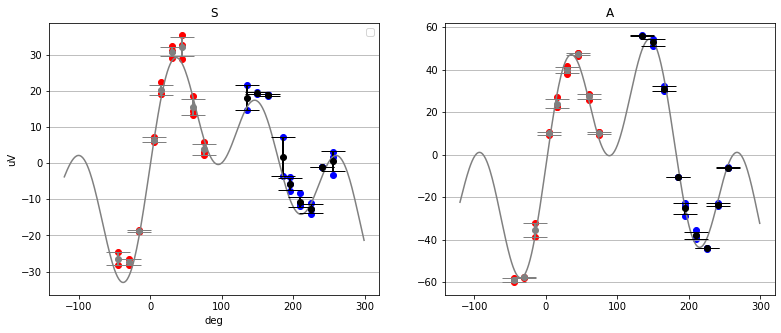

In [68]:
#S & A
plt.figure(figsize = (13,5))
fs, freq=np.array(fs),np.array(freq)

n_shift = 225

fit_x = np.append(fs+45,fs+n_shift)
fit_S = np.append(para_p[:,1],para_n[:,1])
fit_A = np.append(para_p[:,2],para_n[:,2])
para_S,para_A = [30,1,1,4],[30,1,1,4]
x=np.arange(-120,300)
try:
    para_S, cov_S = optimize.curve_fit(Angdep,fit_x,fit_S,[30,1,1,4])
    para_A, cov_A = optimize.curve_fit(Angdep,fit_x,fit_A,[30,1,1,4])
    print('S = ',para_S,'\nA = ',para_A)
    print('S')
    print(para_S[0],cov_S[0][0],para_S[2],cov_S[2][2],para_S[1],cov_S[1][1])
    print(f'{round(para_S[0],6)}*cos((x+{round(para_S[3],3)})/180*pi)*sin(2*(x+{round(para_S[3],3)})/180*pi)\n\
    +{round(para_S[1],6)}*sin((x+{round(para_S[3],3)})/180*pi)*sin(2*(x+{round(para_S[3],3)})/180*pi)\n\
    +{round(para_S[2],6)}*sin(2*(x+{round(para_S[3],3)})/180*pi)')
    print('A')
    print(para_A[0],cov_A[0][0],para_A[2],cov_A[2][2],para_A[1],cov_A[1][1])
    print(f'{round(para_A[0],6)}*cos((x+{round(para_A[3],3)})/180*pi)*sin(2*(x+{round(para_A[3],3)})/180*pi)\n\
    +{round(para_A[1],6)}*sin((x+{round(para_A[3],3)})/180*pi)*sin(2*(x+{round(para_A[3],3)})/180*pi)\n\
    +{round(para_A[2],6)}*sin(2*(x+{round(para_A[3],3)})/180*pi)')
except RuntimeError:
    print('RuntimeError')
    
plt.subplot(121)
plt.title('S')

plt.plot(x,Angdep(x,para_S[0],para_S[1],para_S[2],para_S[3]),color='grey')
plt.scatter(fs+n_shift,para_n[:,1], color='b')
plt.scatter(fs+45,para_p[:,1], color='r')
plt.errorbar(freq+n_shift,para_n_avg[:,1], yerr=para_n_avg[:,2], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,1], yerr=para_p_avg[:,2], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)

plt.ylabel('uV')
plt.xlabel('deg')
plt.grid(axis = 'y')
plt.legend()

#error bar by multiple measurements  
plt.subplot(122)
plt.title('A')
plt.plot(x,Angdep(x,para_A[0],para_A[1],para_A[2],para_A[3]),color='grey')
plt.errorbar(freq+n_shift,para_n_avg[:,3], yerr=para_n_avg[:,4], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,3], yerr=para_p_avg[:,4], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)
plt.scatter(fs+n_shift,para_n[:,2], color='b')
plt.scatter(fs+45,para_p[:,2], color='r')
plt.grid(axis = 'y')

pd.DataFrame(np.around(np.array([fs,para_p[:,1],para_n[:,1],para_p[:,2],para_n[:,2]]),2),\
             columns = file_times, index = ['phi','S+','S-','A+','A-'])

No handles with labels found to put in legend.


,07-22,06-14,08-30,05-06,09-38,45-18,47-34,48-42,44-09,46-26,38-13,35-57,33-41,34-49,37-05,27-33,24-09,26-25,28-42,25-17,11-36,13-52,15-00,16-08,12-44,07-47,06-39,05-31,04-23,03-15,50-22,49-14,47-01,48-06,51-30,50-20,49-16,51-24,53-32,52-28,37-57,39-07,33-59,36-44,41-26,40-17,40-00,38-56,41-04,42-09,37-51,24-20,26-36,25-28,27-44
phi,-120.00,-120.00,-120.00,-120.00,-120.00,-105.00,-105.00,-105.00,-105.00,-105.00,-90.00,-90.00,-90.00,-90.00,-90.00,-75.00,-75.00,-75.00,-75.00,-75.00,-60.00,-60.00,-60.00,-60.00,-60.00,-50.00,-50.00,-50.00,-50.00,-50.00,-30.00,-30.00,-30.00,-30.00,-30.00,-15.00,-15.00,-15.00,-15.00,-15.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,15.00,15.00,15.00,15.00,30.00,30.00,30.00,30.00
H+,524.09,527.05,522.20,523.01,523.05,504.86,502.01,503.12,503.26,503.95,474.31,475.98,474.39,475.42,475.75,459.77,459.60,457.27,460.66,459.77,457.02,455.91,459.19,452.92,457.94,462.22,462.30,457.04,454.64,465.63,475.18,475.29,477.27,465.02,481.99,501.45,496.15,488.52,498.92,491.02,530.45,530.15,535.93,516.55,525.22,526.65,535.02,531.24,528.73,529.31,552.44,561.99,552.71,538.35,547.55
H-,535.96,534.56,535.57,533.73,532.47,516.56,516.01,516.93,517.70,516.42,492.16,492.81,491.87,493.01,492.30,468.04,467.42,467.85,469.26,469.28,467.71,469.01,467.94,467.23,467.96,470.93,466.76,469.36,468.39,469.68,498.62,501.93,501.26,503.95,496.32,517.52,524.20,524.62,526.72,523.08,534.44,530.13,513.91,537.51,529.26,531.97,561.08,563.47,562.51,564.48,551.73,562.65,587.13,578.03,562.00
D+,55.90,53.85,54.87,55.79,54.68,47.82,48.13,47.70,47.27,48.21,49.02,49.10,48.67,49.11,49.78,50.59,51.19,50.84,50.84,49.59,50.20,50.19,52.09,49.76,50.74,56.90,56.13,52.94,56.99,55.18,49.74,51.05,53.96,53.25,52.05,55.39,56.66,54.17,54.58,53.18,49.65,50.37,49.14,50.98,49.99,49.33,44.79,49.75,50.67,48.68,55.98,52.05,45.44,43.55,48.23
D-,50.73,50.79,49.87,50.67,51.72,46.79,47.15,46.73,47.79,47.16,45.07,45.31,44.65,45.62,45.81,45.01,46.46,45.83,45.44,46.29,46.91,46.11,46.60,47.10,46.20,48.91,51.65,51.57,51.79,51.49,47.06,47.64,48.49,50.23,45.19,48.18,46.12,46.55,46.91,45.77,45.26,45.85,51.29,46.22,45.60,44.40,47.15,46.22,45.81,44.40,43.88,59.48,55.51,55.11,50.04


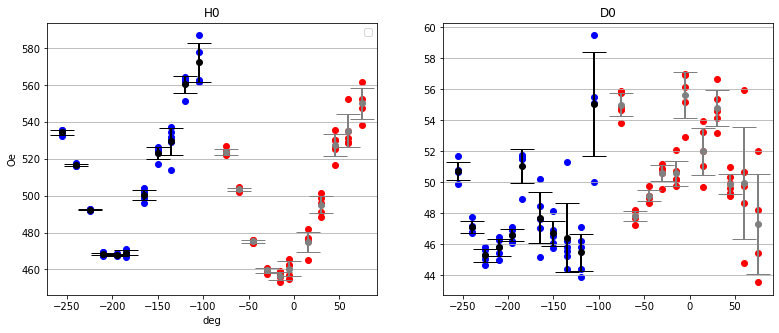

In [8]:
#H0 & Linewidth
plt.figure(figsize = (13,5))

plt.subplot(121)
plt.title('H0')

plt.scatter(fs-135,para_n[:,4], color='blue')
plt.scatter(fs+45,para_p[:,4], color='red')
plt.errorbar(freq-135,para_n_avg[:,7], yerr=para_n_avg[:,8], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,7], yerr=para_p_avg[:,8], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)

plt.ylabel('Oe')
plt.xlabel('deg')
plt.grid(axis = 'y')
plt.legend()

#error bar by multiple measurements  
plt.subplot(122)
plt.title('D0')
plt.errorbar(freq-135,para_n_avg[:,5], yerr=para_n_avg[:,6], fmt='o',ecolor='k',color='k',elinewidth=2,capsize=12)
plt.errorbar(freq+45,para_p_avg[:,5], yerr=para_p_avg[:,6], fmt='o',ecolor='grey',color='grey',elinewidth=2,capsize=12)
plt.scatter(fs-135,para_n[:,3], color='b')
plt.scatter(fs+45,para_p[:,3], color='r')
plt.grid(axis = 'y')

pd.DataFrame(np.around(np.array([fs,para_p[:,4],para_n[:,4],para_p[:,3],para_n[:,3]]),2),\
             columns = file_times, index = ['phi','H+','H-','D+','D-'])

In [9]:
para_n_avg[:,0] -= 180
A = np.vstack((para_p_avg[:,0:5],para_n_avg[:,0:5]))
A[:,0] += 45

NAME='TaCo20Ta'
directory = '/Users/didierjim/Documents/SCREAM/_Analysis/fitted/'
np.savetxt(directory+NAME+'_angdep.csv',A,delimiter=',',header='deg,S,S_err,A,A_err')

#raw fitting
K=np.vstack((para_p,para_n))
np.savetxt(directory+NAME+'angraw.csv',K,delimiter=',',header='f,S,A,D,H0,V0')
print(K[:,0])

[-75. -75. -75. -75. -75. -60. -60. -60. -60. -60. -45. -45. -45. -45.
 -45. -30. -30. -30. -30. -30. -15. -15. -15. -15. -15.  -5.  -5.  -5.
  -5.  -5.  15.  15.  15.  15.  15.  30.  30.  30.  30.  30.  45.  45.
  45.  45.  45.  45.  60.  60.  60.  60.  60.  75.  75.  75.  75. 105.
 105. 105. 105. 105. 120. 120. 120. 120. 120. 135. 135. 135. 135. 135.
 150. 150. 150. 150. 150. 165. 165. 165. 165. 165. 175. 175. 175. 175.
 175. 195. 195. 195. 195. 195. 210. 210. 210. 210. 210. 225. 225. 225.
 225. 225. 225. 240. 240. 240. 240. 240. 255. 255. 255. 255.]


[0, 5, 10, 15, 20, 25, 30, 35, 40, 46, 51]
-75.0
-60.0
-45.0
-30.0
-15.0
-5.0
15.0
30.0
45.0
60.0
75.0
(12, 165) (11, 165)
(165, 23) (136, 23)
Hext,-75.0deg,-60.0deg,-45.0deg,-30.0deg,-15.0deg,-5.0deg,15.0deg,30.0deg,45.0deg,60.0deg,75.0deg,-75.0S+A,-60.0S+A,-45.0S+A,-30.0S+A,-15.0S+A,-5.0S+A,15.0S+A,30.0S+A,45.0S+A,60.0S+A,75.0S+A,


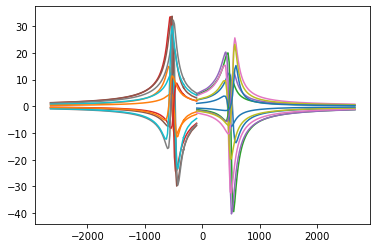

In [10]:
#Curves
pick_ind=[0]
k=0
for i in file_count[:-1]:
    k+=i
    pick_ind.append(k)
    
curves_p1,curves_n1,curves_p2,curves_n2 = [np.array(curves_p[0])],[np.array(curves_n[0])],[],[]
if len(curves_n[0]) == 0:
    print("zero-ind has been assigned a wrong value")
print(pick_ind)
for i in pick_ind:
    print(para_p[i,0])
    L_p = Lorentzian(np.array(curves_p[0]),para_p[i,1],para_p[i,2],para_p[i,3],para_p[i,4],0)
    L_n = Lorentzian(np.array(curves_n[0]),para_n[i,1],-para_n[i,2],para_n[i,3],-para_n[i,4],0)
    
    plt.plot(curves_p[0],L_p)
    plt.plot(curves_n[0],L_n)
    curves_p1.append(curves_p[i+1])
    curves_n1.append(curves_n[i+1])
    curves_p2.append(L_p)
    curves_n2.append(L_n)

print(np.shape(curves_p1),np.shape(curves_p2))
#print(np.array(curves_p[0]))
P=np.vstack((np.array(curves_p1),np.array(curves_p2))).transpose()
N=np.vstack((np.array(curves_n1),np.array(curves_n2))).transpose()
#N[:,0] = -1*N[:,0]
print(np.shape(P),np.shape(N))

header = 'Hext,'
header2 = 'Hext,'
for j in range(2):
    for i in freq:
        if j==0:
            header+=str(i+45)+'deg,'
            header2+=str(i-135)+'deg,'
        elif j==1:
            header+=str(i+45)+'S+A,'
            header2+=str(i-135)+'S+A,'
print(header)
#np.savetxt(directory+NAME+'curP.csv',P,delimiter=',',header=header)
#np.savetxt(directory+NAME+'curN.csv',N,delimiter=',',header=header2)
#6, 9, 1, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4]

# Averaging curves

[5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4]


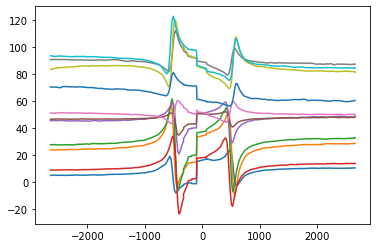

In [11]:
#Averaging curves
n = 0
avg_curves = [x2[:,1]*-1-125]
print(file_count)
for i in range(len(file_count)):
    xj = np.zeros(len(x2))
    for j in range(n,n+file_count[i]):
        import_files = pd.read_csv(files[j])
        result = import_files.values
        
        xj = xj + np.array(result[:,1])
        
    avg_curves.append(xj/file_count[i])
    n+=file_count[i]
    plt.plot(avg_curves[0],avg_curves[i+1])

avg_curves = np.array(avg_curves).transpose()

<Figure size 1080x720 with 0 Axes>

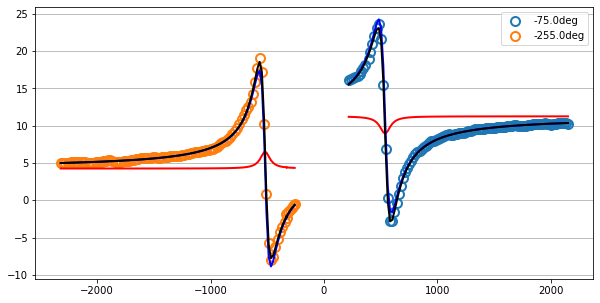

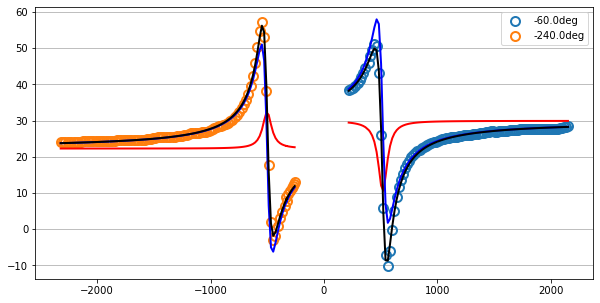

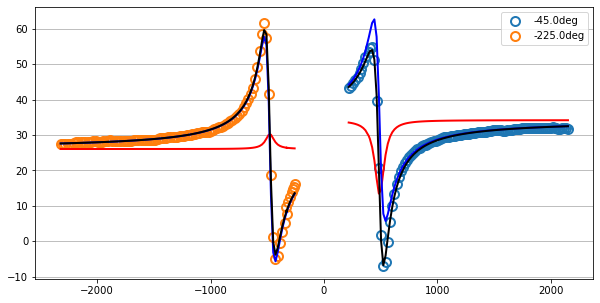

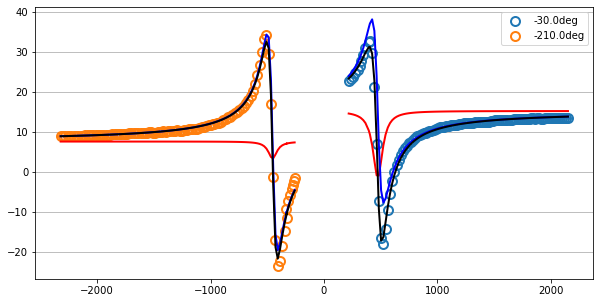

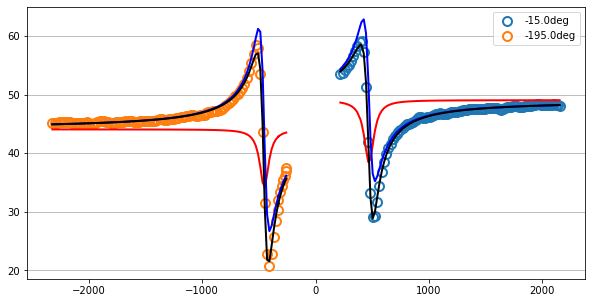

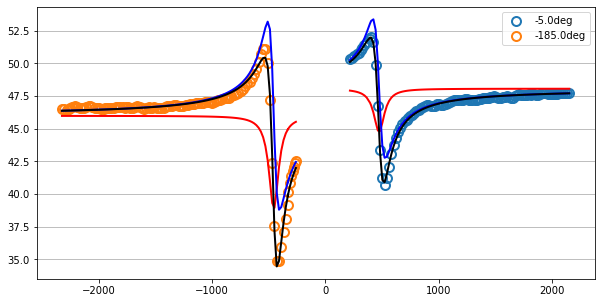

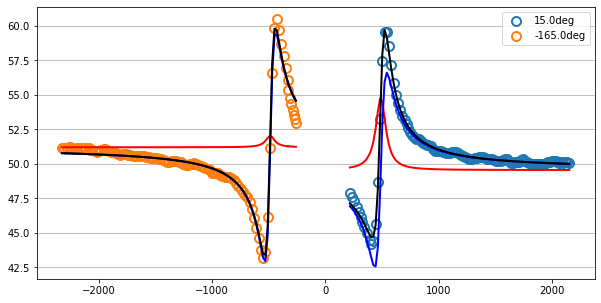

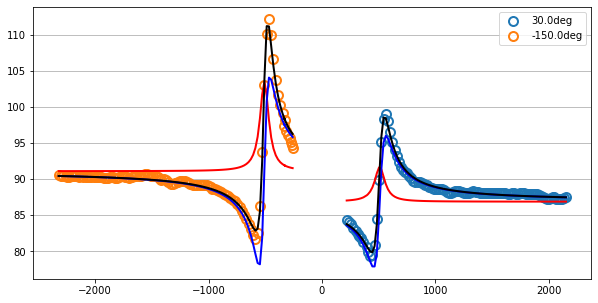

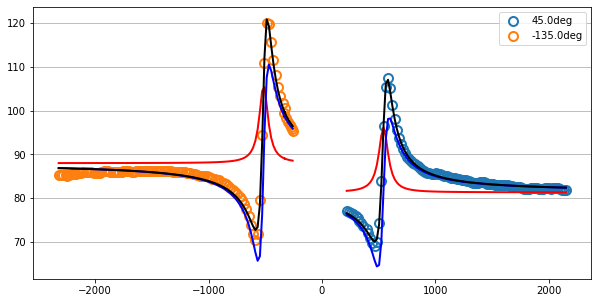

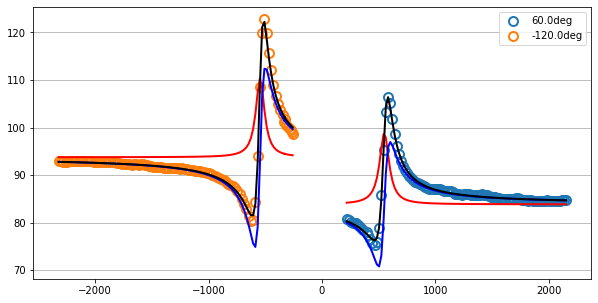

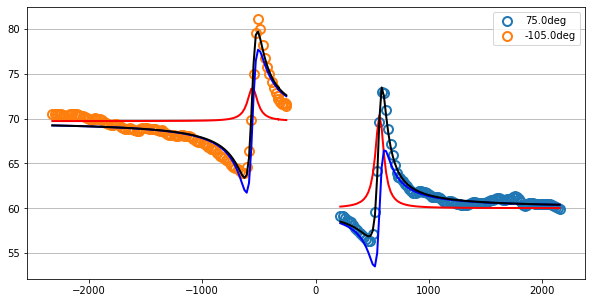

In [12]:
para_p = np.zeros((len(files), 6))
para_n = np.zeros((len(files), 6))
std_err_p = []
std_err_n = []

plt.figure(figsize = (15,10))
for i in range(len(file_count)):
    length = len(x2)
    
    H_p = avg_curves[int(length*0.15):int(length*0.51),0]
    Vmix_p = avg_curves[int(length*0.15):int(length*0.51),i+1]
    
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_p,Vmix_p, [0.0, 0.0, 80, 500, 280])
    except RuntimeError:
        print('RuntimeError (+)',freq[i])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.figure(figsize = (10,5))
    plt.grid(axis = 'y')
    plt.plot(H_p,Vmix_p,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, label = str(freq[i]+45)+'deg')
    plt.plot(H_p, Lorentzian(H_p,para_L[0],0,para_L[2],para_L[3],para_L[4]), color = 'red', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,0,para_L[1],para_L[2],para_L[3],para_L[4]), color = 'blue', linewidth = 2)
    plt.plot(H_p, Lorentzian(H_p,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]),color = 'black', linewidth = 2)
    para_p[i,0] = freq[i]
    para_p[i,1:] = para_L
    std_err_p.append(np.sqrt(np.diag(cov_L))[2])
    
    H_n = avg_curves[int(length*0.58):int(length*0.95),0]
    Vmix_n = avg_curves[int(length*0.58):int(length*0.95),i+1]
    try:
        para_L, cov_L = optimize.curve_fit(Lorentzian,H_n,Vmix_n, [0.0, 0.0, -80, -500, 280])
    except RuntimeError:
        print('RuntimeError (-)',freq[i])
    if para_L[2] < 0:
        para_L[1],para_L[2] = para_L[1]*-1,para_L[2]*-1
    plt.plot(H_n,Vmix_n,'o',markerfacecolor='none',markeredgewidth = 2,markersize = 9, label = str(freq[i]-135)+'deg')
    plt.plot(H_n, Lorentzian(H_n,para_L[0],0,para_L[2],para_L[3],para_L[4]), color = 'red', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,0,para_L[1],para_L[2],para_L[3],para_L[4]), color = 'blue', linewidth = 2)
    plt.plot(H_n, Lorentzian(H_n,para_L[0],para_L[1],para_L[2],para_L[3],para_L[4]),color = 'black', linewidth = 2)
    para_n[i,0] = freq[i]
    para_n[i,1:] = para_L
    std_err_n.append(np.sqrt(np.diag(cov_L))[2])
    

    plt.legend()

In [13]:
#NAME='Cr20Co20-0429'
#directory = '/Users/didierjim/Documents/SCREAM/Analysis/1b1save/'

Hext,-75.0deg,-60.0deg,-45.0deg,-30.0deg,-15.0deg,-5.0deg,15.0deg,30.0deg,45.0deg,60.0deg,75.0deg,


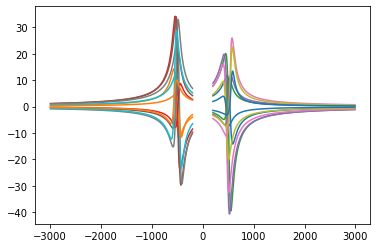

In [14]:
x=np.arange(200, np.max(x2),10)
avg_fit = [np.append(x[::-1],x*-1)]
for i in range(len(file_count)):
    #print(para_p[i,0])
    L_p = Lorentzian(x,para_p[i,1],para_p[i,2],para_p[i,3],para_p[i,4],0)
    L_n = Lorentzian(x,para_n[i,1],-para_n[i,2],para_n[i,3],-para_n[i,4],0)
    avg_curves[avg_curves[:,0]>0,i+1] += -para_p[i,5]
    avg_curves[avg_curves[:,0]<0,i+1] += -para_n[i,5]
    
    plt.plot(x,L_p)
    plt.plot(-x,L_n)
    L = np.append(L_p[::-1],L_n)
    avg_fit.append(L)

avg_fit = np.array(avg_fit).transpose()
    
header = 'Hext,'
for i in freq:
    header+=str(i+45)+'deg,'
    header2+=str(i-135)+'deg,'

print(header)
np.savetxt(directory+NAME+'avg-cur.csv',avg_curves,delimiter=',',header=header)
np.savetxt(directory+NAME+'avg-fit.csv',avg_fit,delimiter=',',header=header)